In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [89]:
df = pd.read_csv('/kaggle/input/churn-modelling/Churn_Modelling.csv')

### Data Preprocessing

In [90]:
# Simplifying column names and bringing consistency
df.columns = [name.lower() for name in list(df.columns)]
df.drop(['rownumber','customerid','surname'],axis=1,inplace=True)
df.rename(columns={"exited": "churn"}, inplace=True)


In [119]:
# Select only the churn customer
df_churn = df[df['churn']==1]

In [120]:
df_churn.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1


#### Transforming

In [121]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [122]:
# Define the columns
numerical = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary', 'numofproducts', 'hascrcard', 'isactivemember']
categorical = ['geography', 'gender']

# Define the column transformer to encode the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical)
    ], remainder='passthrough')  # Passthrough numerical columns for now

# Define a pipeline to first apply the preprocessor and then scale all features
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())  # Scale all features (both encoded and numerical)
])

# Fit the pipeline on the data and transform it
X = df_churn.drop('churn', axis=1)
y = df_churn['churn']
X_transformed = pipeline.fit_transform(X)

# Extract feature names after encoding
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical)
all_feature_names = list(encoded_feature_names) + numerical

# Convert the transformed data back to a DataFrame
df_preprocessed = pd.DataFrame(X_transformed, columns=all_feature_names)

### Model

In [123]:
df_preprocessed

,geography_Germany,geography_Spain,gender_Male,creditscore,age,tenure,balance,estimatedsalary,numofproducts,hascrcard,isactivemember
0,-0.815829,-0.504292,-0.887925,-0.262735,-0.290803,-0.999100,-1.561509,-0.593029,0.656108,1.330950,-0.002017
1,-0.815829,-0.504292,-0.887925,-1.429272,-0.290803,1.044924,1.174917,1.902841,0.656108,-0.751343,0.215307
2,-0.815829,1.982978,1.126221,-0.003505,-0.085868,1.044924,0.388151,0.654906,0.656108,-0.751343,0.834068
3,1.225748,-0.504292,-0.887925,-2.685542,-1.622884,-0.317759,0.410277,3.150776,0.656108,-0.751343,0.308839
4,1.225748,-0.504292,1.126221,0.076259,1.348681,-1.339771,0.711171,-0.593029,0.656108,-0.751343,-1.664439
...,...,...,...,...,...,...,...,...,...,...,...
2032,1.225748,-0.504292,1.126221,-1.469153,-0.290803,-0.658429,1.044299,-0.593029,0.656108,1.330950,-0.829395
2033,1.225748,-0.504292,-0.887925,0.096199,0.119068,0.704254,0.789021,-0.593029,0.656108,-0.751343,0.236289
2034,-0.815829,-0.504292,-0.887925,-0.482084,0.836342,-0.317759,-0.046744,-0.593029,0.656108,-0.751343,-0.554093
2035,-0.815829,-0.504292,-0.887925,0.634601,-0.905610,0.704254,-1.561509,-0.593029,-1.524140,1.330950,-1.025595


In [124]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [125]:
sse = []  # Sum of Squared Errors
cluster_range = range(1, 11)  # Adjust the range if needed

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_preprocessed)
    sse.append(kmeans.inertia_)  # kmeans.inertia_ gives the SSE/WCSS

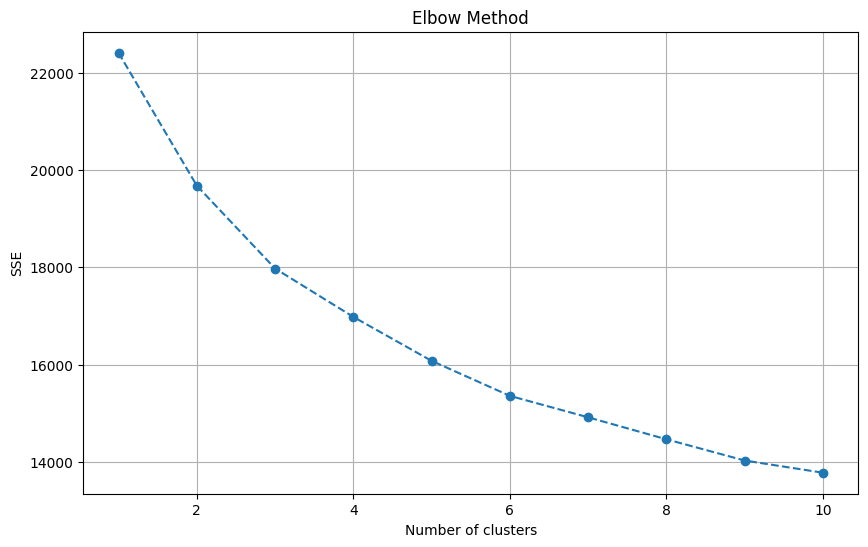

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()


For n_clusters = 2, the average silhouette_score is: 0.11823576065787533


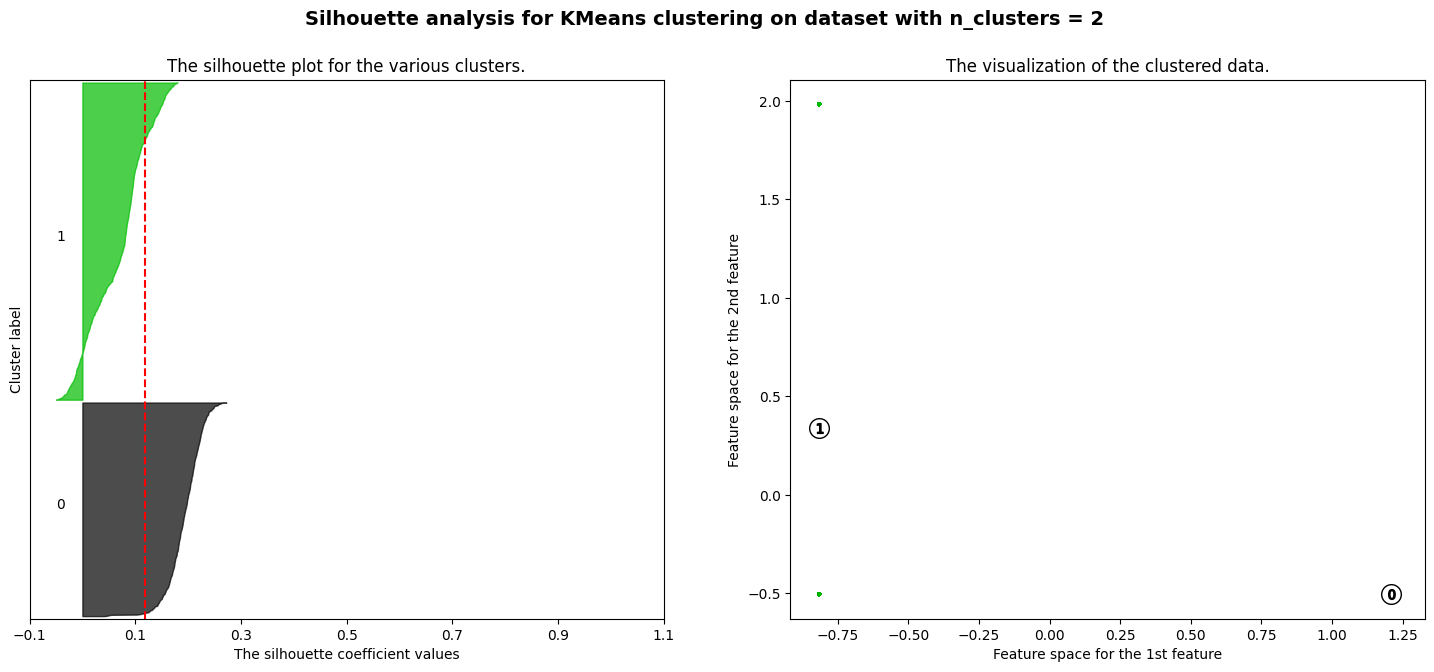

For n_clusters = 3, the average silhouette_score is: 0.12990840647834276


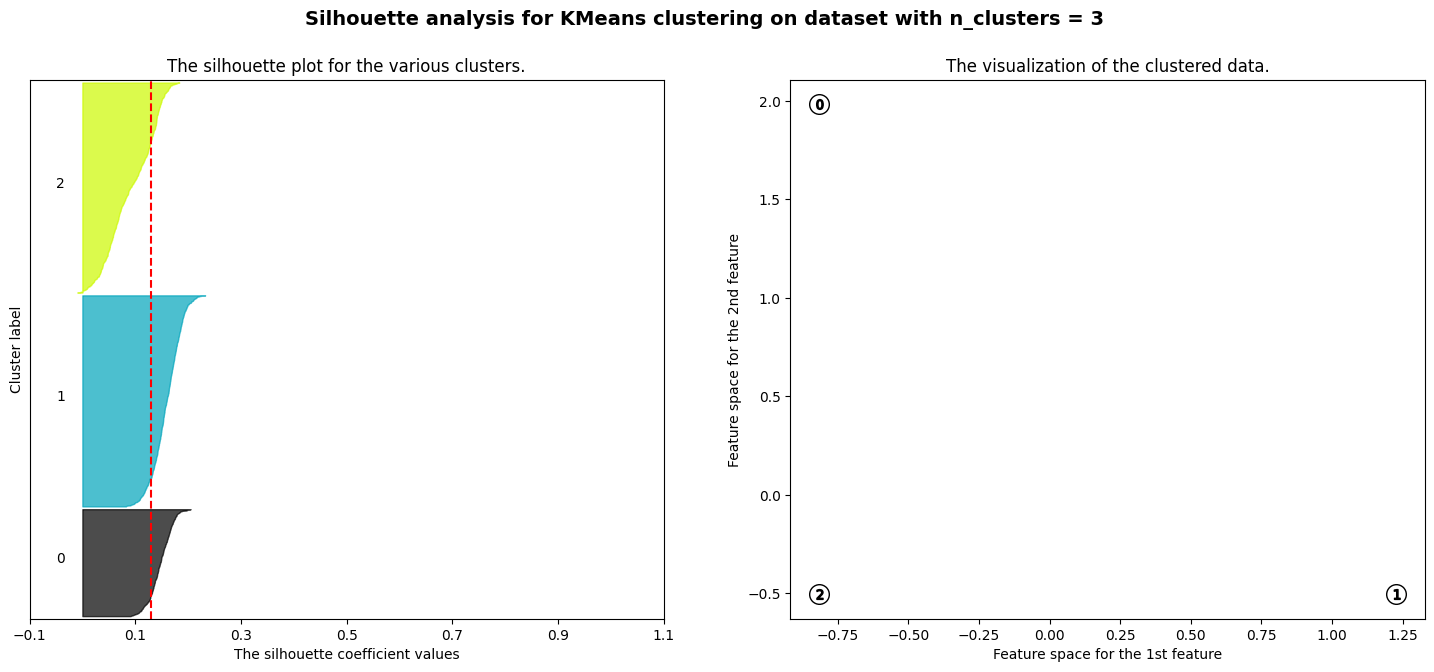

For n_clusters = 4, the average silhouette_score is: 0.11581088738238589


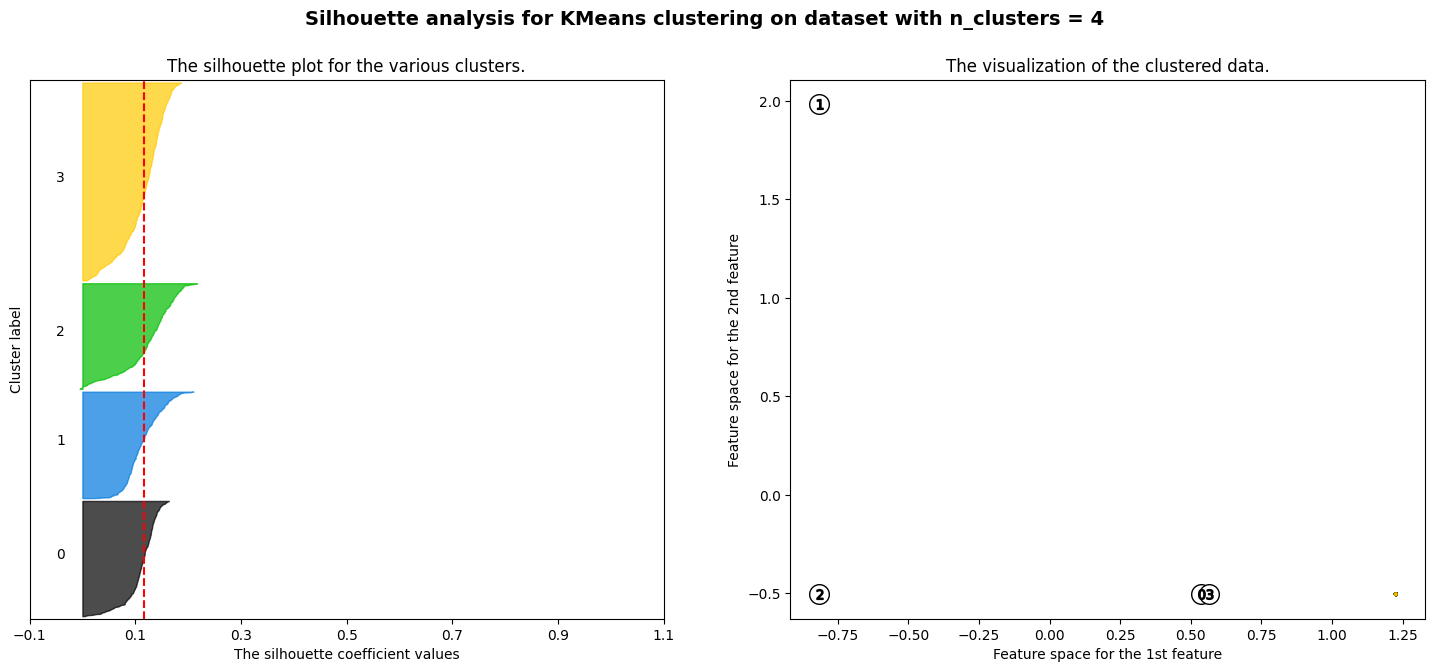

For n_clusters = 5, the average silhouette_score is: 0.11461457479673882


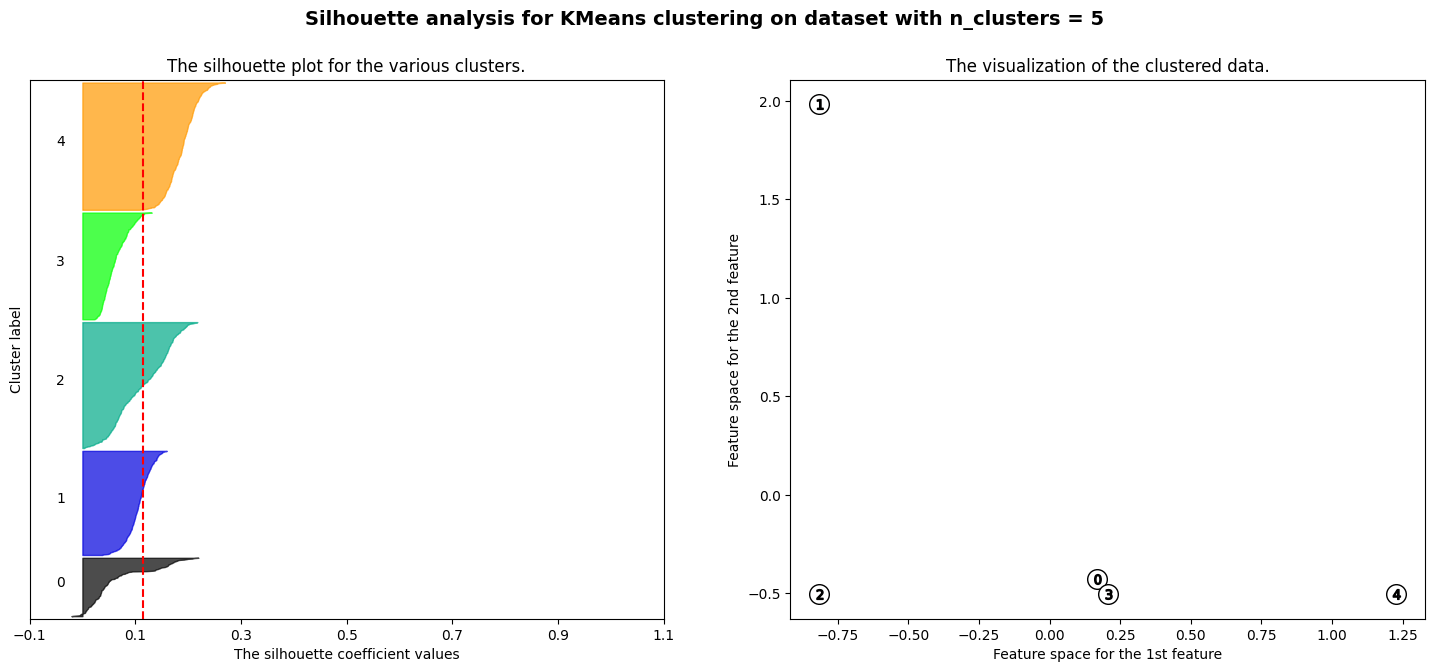

For n_clusters = 6, the average silhouette_score is: 0.10362342163981007


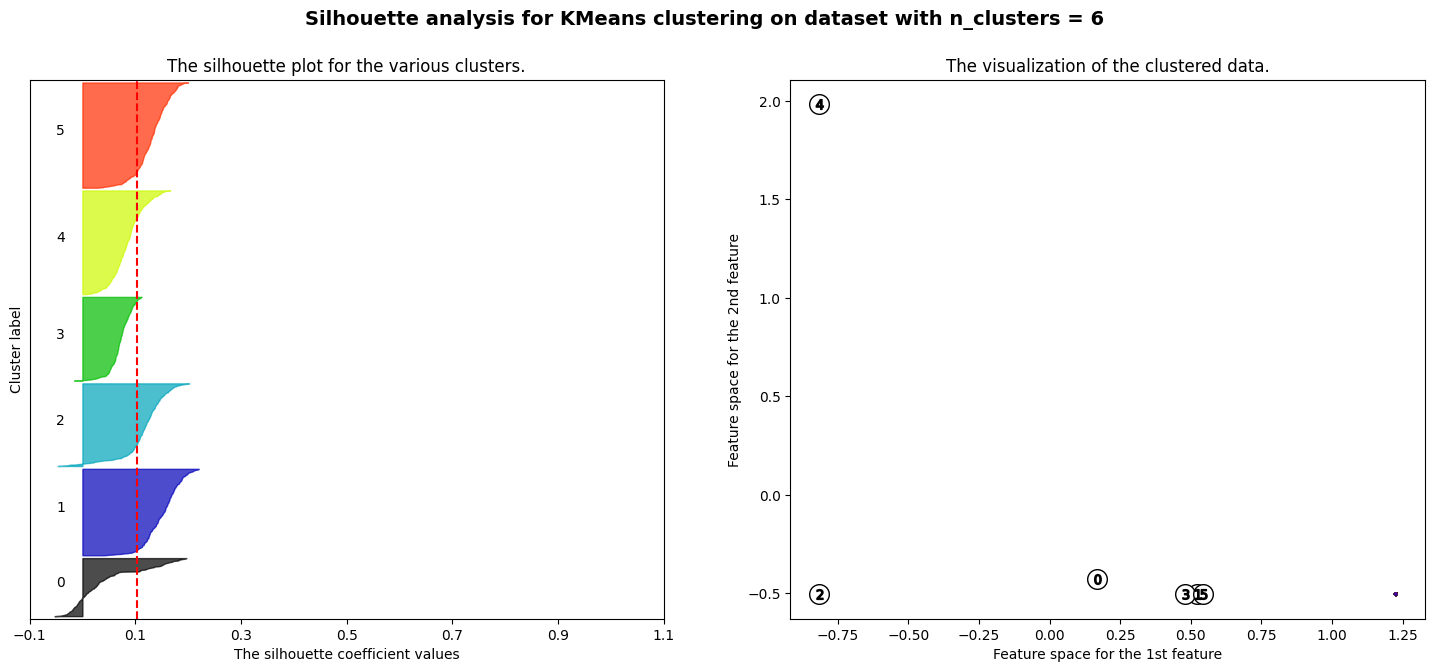

In [127]:
import matplotlib.cm as cm

X = df_preprocessed.values

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on dataset with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

    plt.show()

 Looking at the elbow diagram, the decrease in the plot's slope becomes less visible after reaching a value of k=3.

In [138]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42,n_init=10)
kmeans_model = kmeans.fit(df_preprocessed)

cluster_labels = kmeans_model.predict(df_preprocessed)

In [139]:
df_churn_original = df[df['churn']==1]

In [143]:
df_churn_original['cluster'] = cluster_labels

/tmp/ipykernel_33/3886436945.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [144]:
df_churn_original['cluster'].value_counts()

cluster
1    814
2    810
0    413
Name: count, dtype: int64

#### Visualize the cluster

Due to the excessive number of features, it is advisable to apply Principal Component Analysis (PCA) to reduce them to just three elements. Afterward, we can visualize the data to observe the distinctions.

In [145]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)  # Set the number of components to 3
df_pca = pca.fit_transform(df_preprocessed)


In [149]:
import plotly.express as px

# Assuming df_pca contains your PCA-transformed data
fig = px.scatter_3d(df_pca, x=0, y=1, z=2, color=cluster_labels, labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'})

# Customize the layout if needed
fig.update_layout(scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))

# Show the interactive plot
fig.show()


In [150]:
df_churn_original

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn,cluster
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,2
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9981,498,Germany,Male,42,3,152039.70,1,1,1,53445.17,1,1
9982,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1,1
9991,597,France,Female,53,4,88381.21,1,1,0,69384.71,1,2
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,2


In [151]:
import seaborn as sns

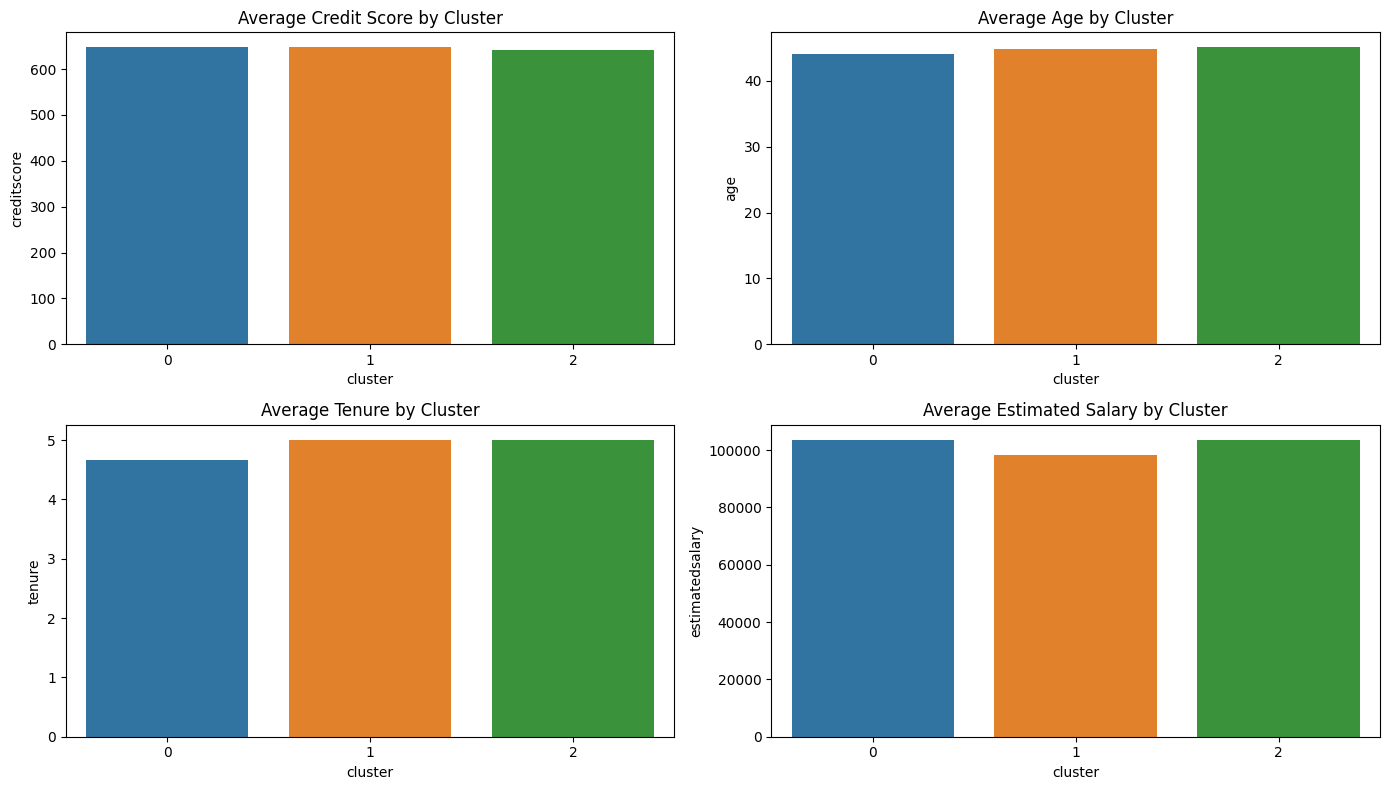

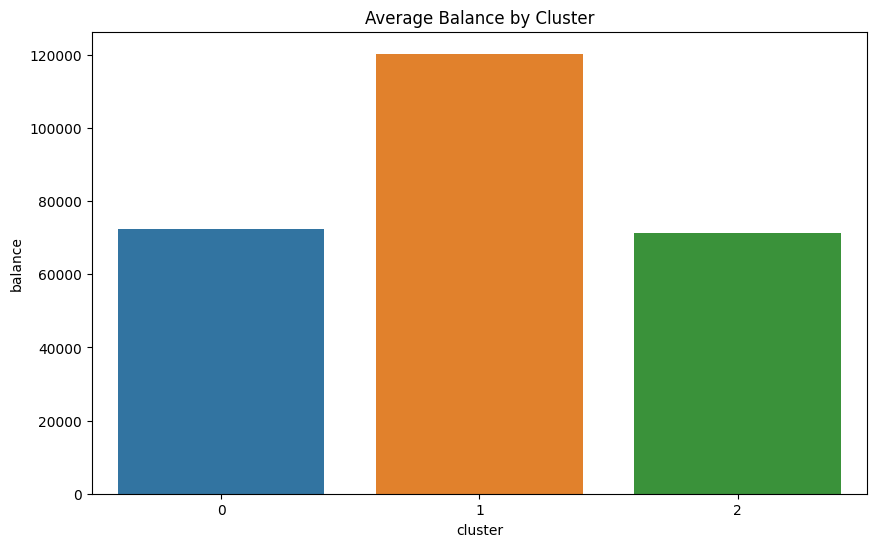

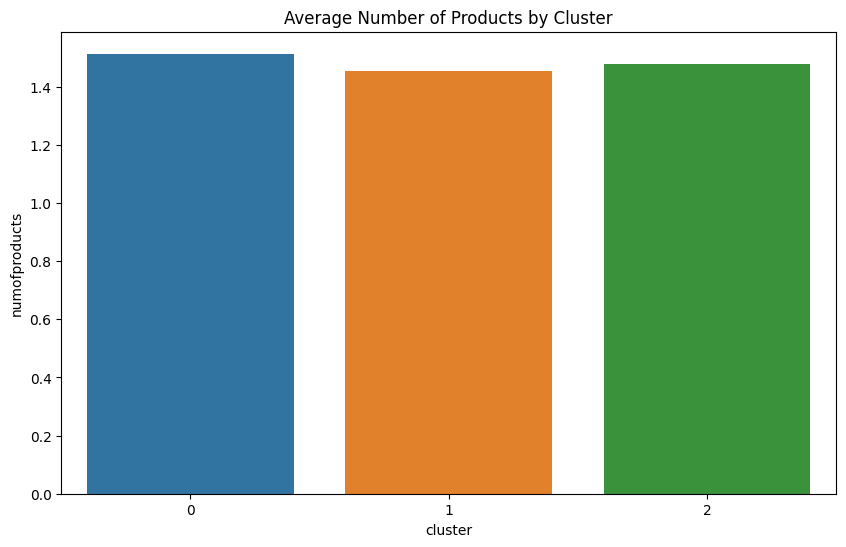

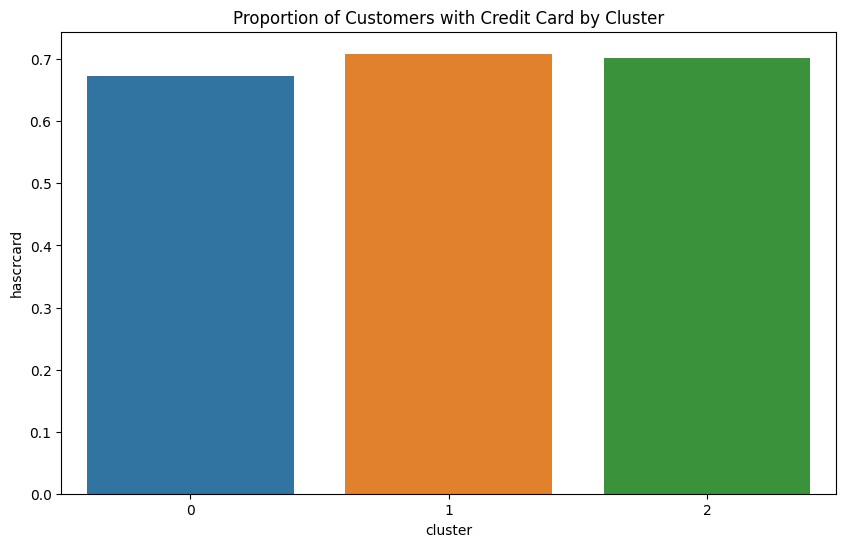

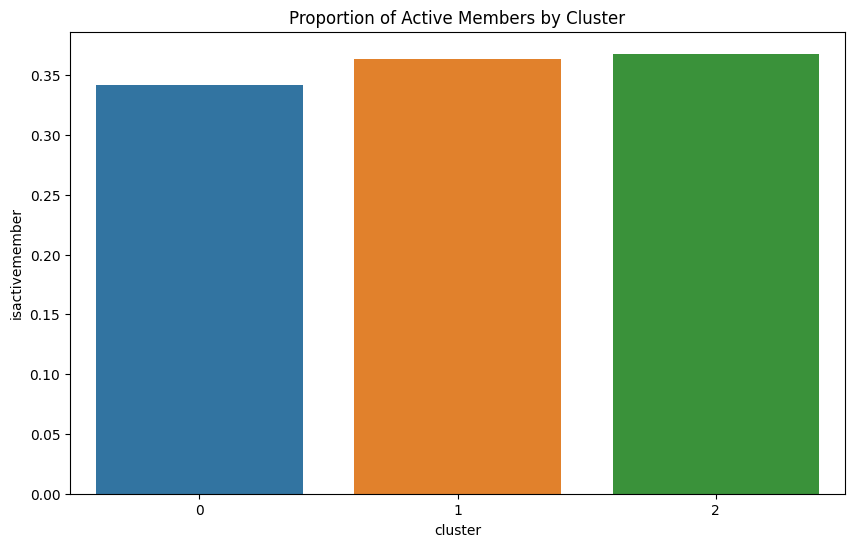

In [152]:
# Create a summary of the clusters
cluster_summary = df_churn_original.groupby('cluster').agg({
    'creditscore': 'mean',
    'age': 'mean',
    'tenure': 'mean',
    'balance': 'mean',
    'estimatedsalary': 'mean',
    'numofproducts': 'mean',
    'hascrcard': 'mean',
    'isactivemember': 'mean'
}).reset_index()

# Create plots to summarize the clusters
plt.figure(figsize=(14, 8))

# Creditscore by Cluster
plt.subplot(2, 2, 1)
sns.barplot(x='cluster', y='creditscore', data=cluster_summary)
plt.title('Average Credit Score by Cluster')

# Age by Cluster
plt.subplot(2, 2, 2)
sns.barplot(x='cluster', y='age', data=cluster_summary)
plt.title('Average Age by Cluster')

# Tenure by Cluster
plt.subplot(2, 2, 3)
sns.barplot(x='cluster', y='tenure', data=cluster_summary)
plt.title('Average Tenure by Cluster')

# Estimated Salary by Cluster
plt.subplot(2, 2, 4)
sns.barplot(x='cluster', y='estimatedsalary', data=cluster_summary)
plt.title('Average Estimated Salary by Cluster')

plt.tight_layout()
plt.show()

# Balance by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='balance', data=cluster_summary)
plt.title('Average Balance by Cluster')
plt.show()

# Number of Products by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='numofproducts', data=cluster_summary)
plt.title('Average Number of Products by Cluster')
plt.show()

# Has Credit Card by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='hascrcard', data=cluster_summary)
plt.title('Proportion of Customers with Credit Card by Cluster')
plt.show()

# Is Active Member by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='isactivemember', data=cluster_summary)
plt.title('Proportion of Active Members by Cluster')
plt.show()